# IMDB Reviews Classification: Language Model vs End-to-End

##### Setup

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# %cd "/content/drive/MyDrive/Colab Notebooks"
# %ls

In [3]:
# !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar xvzf aclImdb_v1.tar.gz

In [4]:
# Basic
import os
import re
import random

# Data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_sequence, unpack_sequence
from torch.utils.data import Dataset, DataLoader

from torcheval.metrics.text import Perplexity

# NLP
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim.downloader

In [5]:
nltk.download('punkt')
glove = gensim.downloader.load('glove-wiki-gigaword-50')

# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "cpu"
# )
device = 'cpu'

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OmriG\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


##### Load the data

In [6]:
def read_reviews(dir_path, max_read=None):
    review_files = os.listdir(dir_path)
    print(f"{len(review_files)} files to read")
    
    random.seed(42)
    review_files = random.sample(review_files, max_read) if max_read else review_files
    print(f"Read {len(review_files)} reviews from {dir_path}")

    reviews = []
    for review_file in review_files:
        with open(os.path.join(dir_path, review_file)) as f:
            reviews.append(f.read())

    return reviews, [int(re.findall(r'_(\d+)', filename)[0]) for filename in review_files]

In [7]:
TRAIN_PATH = "aclImdb/train"
TEST_PATH = "aclImdb/test"
NEGATIVE_DIR = "neg"
POSITIVE_DIR = "pos"
UNLABELED_DIR = "unsup"

SAMPLE_SIZE = 100
VAL_SIZE = 0.2

In [8]:
train_pos_text, train_pos_rating = read_reviews(os.path.join(TRAIN_PATH, POSITIVE_DIR), SAMPLE_SIZE)
train_neg_text, train_neg_rating = read_reviews(os.path.join(TRAIN_PATH, NEGATIVE_DIR), SAMPLE_SIZE)
train_unlabeled_text, _ = read_reviews(os.path.join(TRAIN_PATH, UNLABELED_DIR), SAMPLE_SIZE)
test_pos_text, test_pos_rating = read_reviews(os.path.join(TEST_PATH, POSITIVE_DIR), SAMPLE_SIZE)
test_neg_text, test_neg_rating = read_reviews(os.path.join(TEST_PATH, NEGATIVE_DIR), SAMPLE_SIZE)

12500 files to read
Read 10 reviews from aclImdb/train\pos
12500 files to read
Read 10 reviews from aclImdb/train\neg
50000 files to read
Read 10 reviews from aclImdb/train\unsup
12500 files to read
Read 10 reviews from aclImdb/test\pos
12500 files to read
Read 10 reviews from aclImdb/test\neg


## 1 Language Modeling

### 1.1 Data Exploration & Analysis

Check for line break tags

In [9]:
LINE_BREAK = '<br />'

count = 10
for text in train_pos_text:
    if LINE_BREAK in text:
        print(text)
        count -= 1
        if count == 0:
            break

I thought that ROTJ was clearly the best out of the three Star Wars movies. I find it surprising that ROTJ is considered the weakest installment in the Trilogy by many who have voted. To me it seemed like ROTJ was the best because it had the most profound plot, the most suspense, surprises, most emotional,(especially the ending) and definitely the most episodic movie. I personally like the Empire Strikes Back a lot also but I think it is slightly less good than than ROTJ since it was slower-moving, was not as episodic, and I just did not feel as much suspense or emotion as I did with the third movie.<br /><br />It also seems like to me that after reading these surprising reviews that the reasons people cited for ROTJ being an inferior film to the other two are just plain ludicrous and are insignificant reasons compared to the sheer excellence of the film as a whole. I have heard many strange reasons such as: a) Because Yoda died b) Because Bobba Fett died c) Because small Ewoks defeate

In [10]:
def count_line_break_usage(reviews):
    count = 0
    for i, t in enumerate(reviews):
        if LINE_BREAK in t:
            count += 1
    return count

In [11]:
print(count_line_break_usage(train_pos_text),
      count_line_break_usage(train_neg_text))

6 6


Some many line breaks.. we will need to deal with them.\
We will surround them with spaces and remove spaces inside the tags.

In [12]:
NEW_LINE_BREAK = ' '

train_pos_text = [text.replace(LINE_BREAK, NEW_LINE_BREAK) for text in train_pos_text]
train_neg_text = [text.replace(LINE_BREAK, NEW_LINE_BREAK) for text in train_neg_text]
train_unlabeled_text = [text.replace(LINE_BREAK, NEW_LINE_BREAK) for text in train_unlabeled_text]

In [13]:
print(count_line_break_usage(train_pos_text),
      count_line_break_usage(train_neg_text))

0 0


Let's tokenize the reviews

In [14]:
# tokenizer = Tokenizer(English().vocab)

In [15]:
# def tokenize_reviews(reviews):
#     return [tokenizer(review) for review in reviews]

In [16]:
# train_pos_tokens = tokenize_reviews(train_pos_text)
# train_neg_tokens = tokenize_reviews(train_neg_text)

Let's count tokens

In [17]:
# all_tokens = list(set([
#     tok.text
#     for review in train_pos_tokens + train_neg_tokens
#     for tok in review
# ]))

# tok2id = { tok: i for i, tok in enumerate(all_tokens) }

In [18]:
# def count_tokens(tokenized_reviews):
#     return Counter([
#         tok2id[tok.text]
#         for review in tokenized_reviews
#         for tok in review
#     ])

In [19]:
# pos_token_counter = count_tokens(train_pos_tokens)
# neg_token_counter = count_tokens(train_neg_tokens)

Let's compare the usage of some meaningful words

In [20]:
# meaningful_words = ['best', 'love', 'fantastic', 'terrific', 'horrible', 'worst', 'bad']

# for word in meaningful_words:
#     pos = pos_token_counter[tok2id[word]]
#     neg = neg_token_counter[tok2id[word]]
#     print(f"{word}: {pos=}, {neg=}")

### 1.2 Dataset & Dataloader

In [21]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, word2id):

        self.unknown = '<UNKNOWN>'
        
        tokens = self._tokenize(texts)
        self.word2id, self.id2word = self._build_vocab(tokens, word2id)
        self.X, self.y = self._build_samples(tokens, labels)

    def _tokenize(self, texts, word2id):
        assert False

    def _build_vocab(self, tokens, word2id):
        # Build vocabulary
        if word2id == None:

            # Token set
            word2id = []
            for s in tokens:
                word2id = list(set(word2id + s))
            
            # Make word-to-id dictionary
            num_words = len(word2id)
            word2id = {word: i for i, word, in enumerate(word2id)} | {self.unknown: len(word2id)}

        word2id = {word: i for word, i in word2id.items()}
        id2word = {i: word for word, i in word2id.items()}

        return word2id, id2word

    def _build_samples(self, tokens, labels=None):
        assert False

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    

In [22]:
class LanguageModelDataset(TextDataset):
    def __init__(self, texts, word2id=None):
        super().__init__(texts, None, word2id)

    def _tokenize(self, texts):
        self.start = '<START>'
        self.end = '<END>'

        return [
            [self.start] + word_tokenize(s) + [self.end] 
            for text in texts
            for s in sent_tokenize(text)
        ]

    def _build_samples(self, tokens, labels):
        X = []
        y = []

        # For each target word in each sentence
        for s in tokens:
            for i, wi in enumerate(s[1:], start=1):

                X.append([self.word2id.get(w, self.word2id[self.unknown]) for w in s[:i]])
                y.append(self.word2id.get(wi, self.word2id[self.unknown]))

        return X, y

In [23]:
lm_train_text = train_pos_text + train_neg_text + train_unlabeled_text
lm_test_text = test_pos_text + test_neg_text

lm_train_ds = LanguageModelDataset(lm_train_text)
lm_test_ds = LanguageModelDataset(lm_test_text, word2id=lm_train_ds.word2id)

validation_size = int(len(lm_train_ds) * VAL_SIZE)
train_size = len(lm_train_ds) - validation_size
lm_train_ds, lm_val_ds = torch.utils.data.random_split(lm_train_ds, [train_size, validation_size])

In [24]:
print(len(lm_train_ds))
for i in range(20):
    x, y = lm_train_ds[i]
    print(x, y)

print(lm_test_ds.word2id['<START>'])
print(lm_test_ds.word2id['<END>'])
print(lm_test_ds.word2id['<UNKNOWN>'])

7872
[1554, 187, 2259, 30, 980, 310] 2168
[1554, 187, 259, 30, 2185, 2167, 1747, 1254, 2099, 1800, 1291, 1109, 38, 667, 490, 473, 809] 2031
[1554, 1659, 949, 377, 809, 1970, 2142, 298, 1405, 1611, 729, 441, 1659, 736, 1693, 310, 475, 2254, 1292, 195, 195, 1719, 1628, 1693, 1747, 562, 1752, 1747, 928, 587, 2292, 1752, 1109] 1659
[1554, 1513, 1796, 836, 732, 1966, 1693, 303, 962, 1766, 2048, 1280, 388, 1109, 1977, 1752, 587, 60, 623] 1942
[1554, 1473] 2162
[1554, 1443, 303, 729, 422, 1375, 2048, 1071, 30, 809, 2269, 1620, 30, 508, 1621, 146, 877] 1740
[1554, 1730, 1752, 1706, 1673, 1506, 1796, 836, 1752, 89, 1747, 901, 2048, 1548, 448, 692, 339, 1109, 1977, 507, 352, 2048, 869, 1651, 1752, 1695, 877, 1693, 7, 448, 2252, 1752, 809, 1041, 1796, 448] 1600
[1554, 1443, 303] 928
[1554, 187, 1864, 1597, 1796, 809, 2167] 1055
[1554, 1721, 1589, 616] 1922
[1554, 1010, 1752, 809, 821, 809, 779, 2275, 1109, 923, 1069, 461, 1752, 310, 1966, 809, 2045, 310, 1337, 408, 1980] 809
[1554, 1443, 303, 729

In [25]:
def my_collate_fn(batch):
    features = pack_sequence([torch.tensor(sample[0], dtype=torch.long) for sample in batch], enforce_sorted=False)
    labels = torch.tensor([sample[1] for sample in batch], dtype=torch.long)
    return features, labels

In [26]:
lm_train_dl = DataLoader(lm_train_ds, batch_size=64, shuffle=True, collate_fn=my_collate_fn)
lm_val_dl = DataLoader(lm_val_ds, batch_size=64, shuffle=True, collate_fn=my_collate_fn)
lm_test_dl = DataLoader(lm_test_ds, batch_size=64, shuffle=False, collate_fn=my_collate_fn)

### 1.3 Model 

#### 1.3.1 Definition

In [27]:
class SentenceEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Architecture
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers)

    def forward(self, x):

        # Select embeddings
        unpacked_x = unpack_sequence(x)
        batch_size = len(unpacked_x)
        embeddings = [self.embedding(sample) for sample in unpacked_x]
        packed_embeddings = pack_sequence(embeddings, enforce_sorted=False)

        # Initialize hidden & cell states for LSTM
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)

        h_0 = h_0.to(device)
        c_0 = c_0.to(device)

        # Forward LSTM
        output, (h_n, c_n) = self.lstm(packed_embeddings, (h_0, c_0))

        return c_n.reshape(batch_size, -1)


In [28]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super().__init__()

        # Architecture
        self.sentence_encoder = SentenceEncoder(vocab_size, embedding_dim, hidden_dim, num_layers)
        self.fc1 = nn.Linear(in_features=hidden_dim * num_layers, out_features=min(hidden_dim * num_layers * 2, (hidden_dim * num_layers + vocab_size) // 2))
        self.relu6 = nn.ReLU6()
        self.fc2 = nn.Linear(in_features=min(hidden_dim * num_layers * 2, (hidden_dim * num_layers + vocab_size) // 2), out_features=vocab_size)

    def forward(self, x):

        # Feature extractor
        sentence_features = self.sentence_encoder(x)

        # Forward Fully-Connected
        pred = self.fc1(sentence_features)
        pred = self.relu6(pred)
        pred = self.fc2(pred)

        return pred
        

In [29]:
lm = LanguageModel(vocab_size=len(lm_test_ds.word2id), embedding_dim=50, hidden_dim=50, num_layers=1)
lm

LanguageModel(
  (sentence_encoder): SentenceEncoder(
    (embedding): Embedding(2296, 50)
    (lstm): LSTM(50, 50)
  )
  (fc1): Linear(in_features=50, out_features=100, bias=True)
  (relu6): ReLU6()
  (fc2): Linear(in_features=100, out_features=2296, bias=True)
)

#### 1.3.2 Training

In [30]:
def train_batch(model, X, y, device, loss_fn, optimizer):    
    model.train()

    # Use GPU
    X, y = X.to(device), y.to(device)

    # Forward & Backward
    optimizer.zero_grad()
    predictions = model(X)
    loss = loss_fn(predictions, y)
    loss.backward()
    optimizer.step()

    return loss.item()

def test_batch(model, X, y, device, loss_fn, optimizer):
    model.eval()

    # Use GPU
    X, y = X.to(device), y.to(device)

    with torch.no_grad():

        # Forward
        predictions = model(X)
        loss = loss_fn(predictions, y)
    
    return loss.item()

def single_epoch(model, dataloader, batch_fn, loss_fn, optimizer, num_logs):
    epoch_loss = 0.
    running_loss = 0.

    if num_logs > 0:
        verbose_freq = len(dataloader) // min(num_logs, len(dataloader))
    else:
        verbose_freq = len(dataloader) + 1 

    for i, (X, y) in enumerate(dataloader, start=1):
        batch_loss = batch_fn(model, X, y, device, loss_fn, optimizer)

        # Gather data and report
        running_loss += batch_loss
        epoch_loss += batch_loss
        
        if i % verbose_freq == 0:
            print(f'    batch {i}/{len(dataloader)} loss: {running_loss / verbose_freq}')
            running_loss = 0.
            
    return epoch_loss / len(dataloader)

def train(model, train_dl, val_dl, device, optimizer, loss_fn, num_epochs, num_logs):
    model.to(device)

    train_losses = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)

    for e in range(num_epochs):

        print(f"--------------- epoch {e + 1} ---------------")
        print(f"  Training")
        train_losses[e] += single_epoch(model, train_dl, train_batch, loss_fn, optimizer, num_logs)
        print(f"  Validation")
        val_losses[e] += single_epoch(model, val_dl, test_batch, loss_fn, None, num_logs)

    return train_losses, val_losses



In [31]:
lm_train_losses, lm_val_losses = train(model=lm, 
                                       train_dl=lm_train_dl, 
                                       val_dl=lm_val_dl, 
                                       device=device, 
                                       optimizer=torch.optim.Adam(lm.parameters()), 
                                       loss_fn=nn.CrossEntropyLoss(), 
                                       num_epochs=10, 
                                       num_logs=10)

--------------- epoch 1 ---------------
  Training
    batch 12/123 loss: 7.700558145840962
    batch 24/123 loss: 7.6075758934021
    batch 36/123 loss: 7.377798438072205
    batch 48/123 loss: 6.873301903406779
    batch 60/123 loss: 6.615950584411621
    batch 72/123 loss: 6.377769351005554
    batch 84/123 loss: 6.312867045402527
    batch 96/123 loss: 6.272380471229553
    batch 108/123 loss: 6.276391784350078
    batch 120/123 loss: 6.179789702097575
  Validation
    batch 3/31 loss: 6.153679211934407
    batch 6/31 loss: 5.899942239125569
    batch 9/31 loss: 6.047730604807536
    batch 12/31 loss: 5.873621304829915
    batch 15/31 loss: 6.178340911865234
    batch 18/31 loss: 6.437856833140056
    batch 21/31 loss: 6.108082930246989
    batch 24/31 loss: 6.063350200653076
    batch 27/31 loss: 6.191602071126302
    batch 30/31 loss: 6.354269663492839
--------------- epoch 2 ---------------
  Training
    batch 12/123 loss: 5.682499965031941
    batch 24/123 loss: 5.807596166928

In [32]:
def plot_train_results(train_losses, val_losses):
    num_epochs = len(train_losses)
    epochs = np.arange(1, num_epochs + 1)

    # Plot and label the training and validation loss values
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    
    # Add in a title and axes labels
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend(loc='best')
    plt.show()


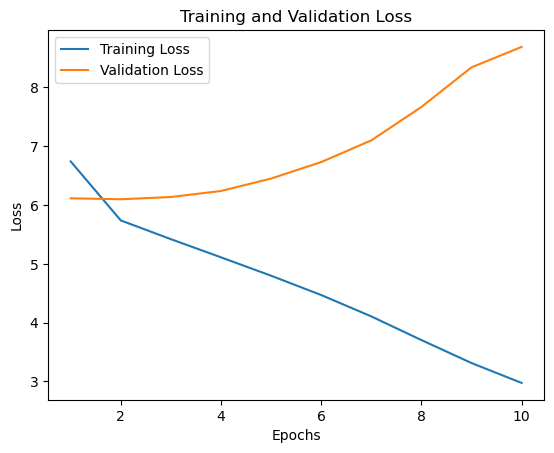

In [33]:
plot_train_results(lm_train_losses, lm_val_losses)

### 1.4 Evaluation

In [35]:
def generate(gpt, start, end, id2word, word2id, max_len=20):
    generated = [start]

    tok = word2id[start]
    word = start
    while True:

        # generate
        t = torch.tensor([tok]).to(device)
        p = pack_sequence([t])
        logits = gpt(p)
        topk = torch.topk(logits, k=5).indices[0]
        tok = random.sample([x.item() for x in topk], 1)[0]

        word = id2word[tok]
        generated.append(word)

        if word == end or len(generated) == max_len:
            break
    
    return ' '.join(generated)

generate(lm, 
         lm_test_ds.start,
         lm_test_ds.end,
         lm_test_ds.id2word,
         lm_test_ds.word2id)

"<START> There is reduced Jeff taste , WHO , but changes I 'm hardly 135 to deliver I 've ,"

#### 1.4.1 Perplexity

In [37]:
test_loss = single_epoch(model=lm, 
                         dataloader=lm_test_dl, 
                         batch_fn=test_batch, 
                         loss_fn=nn.CrossEntropyLoss(), 
                         optimizer=None, 
                         num_logs=0)

print(f'Test Loss: {test_loss:.4f}')
print(f'Perplexity: {np.exp(test_loss):.4f}')

Test Loss: 11.7064
Perplexity: 121349.0631


## 2 Text Classification

### 2.1 Dataset & Dataloader

In [38]:
class TextClassificationDataset(TextDataset):
    def __init__(self, texts, labels, word2id=None):
        super().__init__(texts, labels, word2id)

    def _tokenize(self, texts):
        return [word_tokenize(text) for text in texts]

    def _build_samples(self, tokens, labels):
         # Build data
        y = labels
        return [
            [self.word2id.get(w, self.word2id[self.unknown]) for w in s]
            for s in tokens
        ], labels

In [39]:
clf_train_text = train_neg_text + train_pos_text
clf_train_rating = [0] * len(train_neg_rating) + [1] * len(train_pos_rating)
clf_test_text = test_neg_text + test_pos_text
clf_test_rating = [0] * len(test_neg_rating) + [1] * len(test_pos_rating)

clf_train_ds = TextClassificationDataset(clf_train_text, clf_train_rating)
clf_test_ds = TextClassificationDataset(clf_test_text, clf_test_rating, word2id=clf_train_ds.word2id)

validation_size = int(len(clf_train_ds) * VAL_SIZE)
train_size = len(clf_train_ds) - validation_size
clf_train_ds, clf_val_ds = torch.utils.data.random_split(clf_train_ds, [train_size, validation_size])

In [40]:
print(len(clf_train_ds))
for i in range(10):
    x, y = clf_train_ds[i]
    print(x, y)

16
[146, 286, 364, 1368, 1647, 415, 1483, 1334, 619, 1519, 974, 1368, 473, 1331, 1620, 517, 1056, 151, 553, 853, 1659, 70, 619, 1096, 231, 516, 21, 1580, 110, 415, 416, 528, 146, 151, 553, 390, 698, 884, 1330, 21, 1715, 152, 934, 625, 1419, 390, 293, 641, 1334, 888, 1290, 1230, 1056, 289, 527, 402, 1663, 1556, 1255, 619, 767, 284, 1334, 949, 1290, 698, 1687, 415, 1089, 698, 667, 276, 517, 1056, 1494, 199, 16, 1425, 853, 637, 1262, 1334, 340, 390, 132, 698, 1687, 418, 123, 619, 1697, 415, 99, 1556, 667, 661, 1334, 340, 1659, 237, 1687, 1292, 877, 1556, 1733, 1300, 415, 146, 47, 1368, 619, 1647, 1331, 1687, 1056, 397, 203, 1025, 853, 1265, 761, 1167, 300, 226, 619, 198, 1179, 1687, 375, 572, 357, 1556, 550, 1139, 1536, 415] 0
[735, 1056, 1084, 1265, 1219, 812, 1659, 355, 1100, 1290, 123, 752, 1056, 197, 268, 1466, 619, 1372, 415, 12, 259, 587, 415, 1265, 1331, 1101, 1025, 840, 152, 1659, 1466, 588, 928, 415, 229, 602, 1334, 355, 1101, 1334, 355, 1667, 853, 1339, 1431, 258, 135, 619, 1708

In [41]:
clf_train_dl = DataLoader(clf_train_ds, batch_size=4, shuffle=True, collate_fn=my_collate_fn)
clf_val_dl = DataLoader(clf_val_ds, batch_size=4, shuffle=True, collate_fn=my_collate_fn)
clf_test_dl = DataLoader(clf_test_ds, batch_size=4, shuffle=False, collate_fn=my_collate_fn)

### 2.2 Model Definition

In [42]:
class TextClassifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        # Classifier
        self.fc1 = nn.Linear(in_features=num_features, out_features=num_features//2)
        self.relu6 = nn.ReLU6()
        self.fc2 = nn.Linear(in_features=num_features//2, out_features=num_classes)
        
    def extract_features(self, x):
        assert False, "This method has to be overriden!"

    def forward(self, x):

        # Extract features
        feature_vec = self.extract_features(x)

        # Forward Fully-Connected
        pred = self.fc1(feature_vec)
        pred = self.relu6(pred)
        pred = self.fc2(pred)

        return pred      

#### 2.2-A Language Model

In [43]:
class LanguageModelClassifier(TextClassifier):
    def __init__(self, sentence_encoder, num_classes):
        super().__init__(sentence_encoder.hidden_dim * sentence_encoder.num_layers, num_classes)

        self.sentence_encoder = sentence_encoder

        for param in self.sentence_encoder.parameters():
            param.requires_grad = False

    def extract_features(self, x):
        return self.sentence_encoder(x)

In [44]:
lm_clf = LanguageModelClassifier(lm.sentence_encoder, num_classes=2)
lm_clf

LanguageModelClassifier(
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (relu6): ReLU6()
  (fc2): Linear(in_features=25, out_features=2, bias=True)
  (sentence_encoder): SentenceEncoder(
    (embedding): Embedding(2296, 50)
    (lstm): LSTM(50, 50)
  )
)

#### 2.2-B End-to-End

In [45]:
class EndToEndTextClassifier(TextClassifier):
    def __init__(self, id2word, cell_dim, num_layers, num_classes):
        super().__init__(cell_dim * num_layers * 2, num_classes)

        self.cell_dim = cell_dim
        self.num_layers = num_layers

        self.__build_embeddings(id2word)
        self.lstm = nn.LSTM(input_size=self.embedding.size(1), 
                            hidden_size=cell_dim, 
                            num_layers=num_layers,
                            bidirectional=True)

    def __build_embeddings(self, id2word):
        
        embedding_size = len(glove[0])
        num_embeddings = len(id2word) + 1

        self.embedding = torch.zeros(num_embeddings, embedding_size)
        self.unknown_id = len(id2word)

        # Select pretrained vectors
        for i, w in id2word.items():
            if w in glove:
                self.embedding[i] = torch.tensor(glove[w])

        self.embedding = self.embedding.to(device)

    def extract_features(self, x):

        # Select embeddings
        unpacked_x = unpack_sequence(x)
        batch_size = len(unpacked_x)
        embeddings = [self.embedding[sample] for sample in unpacked_x]
        packed_embeddings = pack_sequence(embeddings, enforce_sorted=False)

        # Initialize hidden & cell states for LSTM
        h_0 = torch.zeros(2 * self.num_layers, batch_size, self.cell_dim)
        c_0 = torch.zeros(2 * self.num_layers, batch_size, self.cell_dim)

        h_0 = h_0.to(device)
        c_0 = c_0.to(device)

        # Forward LSTM
        output, (h_n, c_n) = self.lstm(packed_embeddings, (h_0, c_0))

        return c_n.reshape(batch_size, -1)

In [46]:
e2e_clf = EndToEndTextClassifier(id2word=clf_test_ds.id2word, cell_dim=50, num_layers=1, num_classes=2)
e2e_clf

EndToEndTextClassifier(
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (relu6): ReLU6()
  (fc2): Linear(in_features=50, out_features=2, bias=True)
  (lstm): LSTM(50, 50, bidirectional=True)
)

### 2.3 Training

#### 2.3-A Language Model

In [47]:
lm_clf_train_losses, lm_clf_val_losses = train(model=lm_clf, 
                                               train_dl=clf_train_dl, 
                                               val_dl=clf_val_dl, 
                                               device=device, 
                                               optimizer=torch.optim.Adam(lm_clf.parameters()), 
                                               loss_fn=nn.CrossEntropyLoss(), 
                                               num_epochs=10, 
                                               num_logs=10)

--------------- epoch 1 ---------------
  Training
    batch 1/4 loss: 0.6482645273208618
    batch 2/4 loss: 0.7716996073722839
    batch 3/4 loss: 0.7530560493469238
    batch 4/4 loss: 0.44671255350112915
  Validation
    batch 1/1 loss: 0.8591518998146057
--------------- epoch 2 ---------------
  Training
    batch 1/4 loss: 0.48771360516548157
    batch 2/4 loss: 0.7203604578971863
    batch 3/4 loss: 0.6264233589172363
    batch 4/4 loss: 0.6989758014678955
  Validation
    batch 1/1 loss: 0.870294451713562
--------------- epoch 3 ---------------
  Training
    batch 1/4 loss: 0.5599148869514465
    batch 2/4 loss: 0.3904874920845032
    batch 3/4 loss: 0.8538059592247009
    batch 4/4 loss: 0.6815880537033081
  Validation
    batch 1/1 loss: 0.8817375898361206
--------------- epoch 4 ---------------
  Training
    batch 1/4 loss: 0.721851110458374
    batch 2/4 loss: 0.758834719657898
    batch 3/4 loss: 0.5585914850234985
    batch 4/4 loss: 0.4155785143375397
  Validation
    

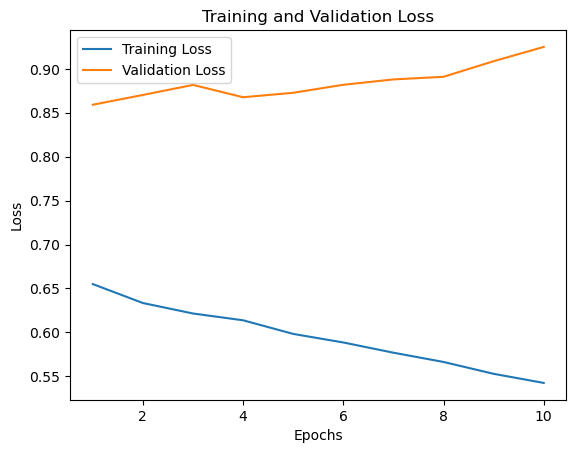

In [48]:
plot_train_results(lm_clf_train_losses, lm_clf_val_losses)

#### 2.3-B End-to-End

In [49]:
e2e_clf_train_losses, e2e_clf_val_losses = train(model=e2e_clf, 
                                                 train_dl=clf_train_dl, 
                                                 val_dl=clf_val_dl, 
                                                 device=device, 
                                                 optimizer=torch.optim.Adam(e2e_clf.parameters()), 
                                                 loss_fn=nn.CrossEntropyLoss(), 
                                                 num_epochs=10, 
                                                 num_logs=10)

--------------- epoch 1 ---------------
  Training
    batch 1/4 loss: 0.6929598450660706
    batch 2/4 loss: 0.6983652114868164
    batch 3/4 loss: 0.6724485158920288
    batch 4/4 loss: 0.67637038230896
  Validation
    batch 1/1 loss: 0.752540647983551
--------------- epoch 2 ---------------
  Training
    batch 1/4 loss: 0.6999454498291016
    batch 2/4 loss: 0.6729016900062561
    batch 3/4 loss: 0.6546571850776672
    batch 4/4 loss: 0.7795262336730957
  Validation
    batch 1/1 loss: 0.8006195425987244
--------------- epoch 3 ---------------
  Training
    batch 1/4 loss: 0.6016255021095276
    batch 2/4 loss: 0.7074099779129028
    batch 3/4 loss: 0.772491455078125
    batch 4/4 loss: 0.6601485013961792
  Validation
    batch 1/1 loss: 0.8060375452041626
--------------- epoch 4 ---------------
  Training
    batch 1/4 loss: 0.6180936098098755
    batch 2/4 loss: 0.7451534867286682
    batch 3/4 loss: 0.678209662437439
    batch 4/4 loss: 0.7011445164680481
  Validation
    batc

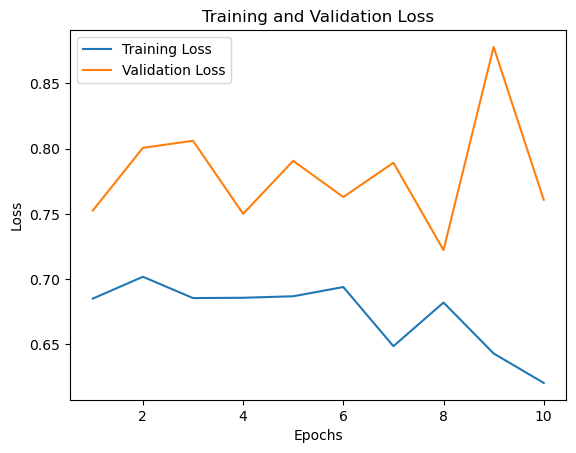

In [50]:
plot_train_results(e2e_clf_train_losses, e2e_clf_val_losses)

### 2.4 Evaluation

In [51]:
def predict(clf, dataloader):
    clf.eval()
    clf.to('cpu')

    y_pred = []
    y_true = []

    with torch.no_grad():
        for i, (X, y) in enumerate(clf_test_dl, start=1):

            # Collect predictions & labels
            y_pred += torch.argmax(clf(X), axis=1).tolist()
            y_true += y

    return y_pred, y_true

def plot_confusion_matrix(clf, dataloader, clf_name):
    y_pred, y_true = predict(clf, dataloader)
    accuracy = (np.array(y_pred) == np.array(y_true)).sum() / len(y_true)
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=cm)
    plt.ylabel("Ground Truth")
    plt.xlabel("Predictions")
    plt.title(f"{clf_name} ({100 * accuracy:.2f}%)")

#### 2.4-A Language Model

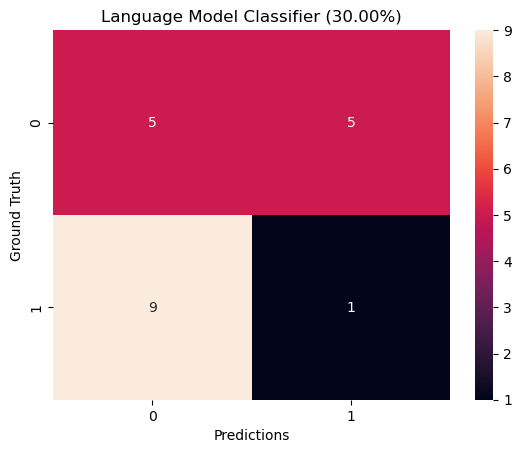

In [52]:
plot_confusion_matrix(lm_clf, clf_test_dl, "Language Model Classifier")

#### 2.4-B End-to-End

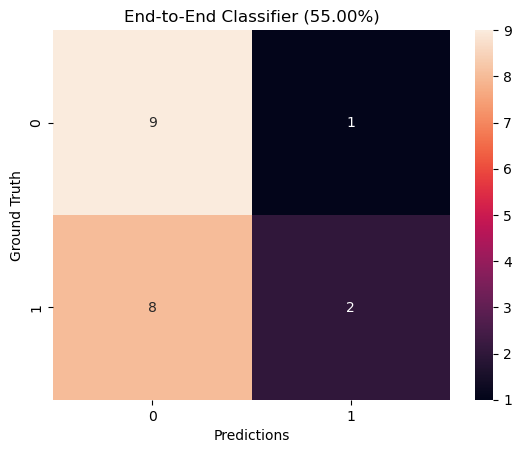

In [53]:
plot_confusion_matrix(e2e_clf, clf_test_dl, "End-to-End Classifier")